In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import galsim
import cv2 as cv
import plot_utils

%matplotlib inline
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
dat = np.load('Data/Cat-SFG-17-01-2020.npz')
dat.files

['nobj', 'listgal', 'flux1400sfg', 'sizesfg', 'randidx', 'e1', 'e2']

In [3]:
dat['listgal'].shape

(300, 96, 96)

In [4]:
img1 = np.abs(fits.open('Data/psf2asec-96.psf.fits')[0].data[0,0,:,:])

### Loading PSF & SFG

In [5]:
gal = cv.resize(dat['listgal'][0,:,:], (64,64))
psf = cv.resize(galsim.Image(img1, copy=True).array, (64,64))

gal_up = cv.resize(dat['listgal'][0,:,:], (64*4,64*4))                   # Upsampled to remove alising
psf_up = cv.resize(galsim.Image(img1, copy=True).array, (64*4,64*4))

psf /= np.sum(psf)             # PSF flux = 1
psf_up /= np.sum(psf_up)

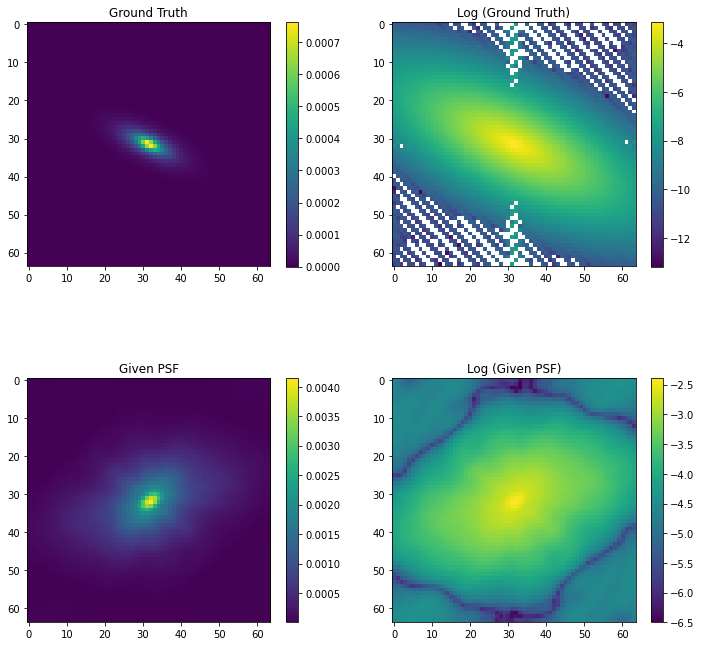

In [6]:
fig = plt.figure(figsize=(12,12))

plt.subplot(221)
plt.imshow(gal)
plt.colorbar(shrink=0.825)
plt.title('Ground Truth')

plt.subplot(222)
plt.imshow(np.log10(gal))
plt.colorbar(shrink=0.825)
plt.title('Log (Ground Truth)')

plt.subplot(223)
plt.imshow(psf)
plt.colorbar(shrink=0.825)
plt.title('Given PSF')

plt.subplot(224)
plt.imshow(np.log10(psf))
plt.colorbar(shrink=0.825)
plt.title('Log (Given PSF)')

plt.show()

### FFT(Ground Truth) + Gaussian Noise

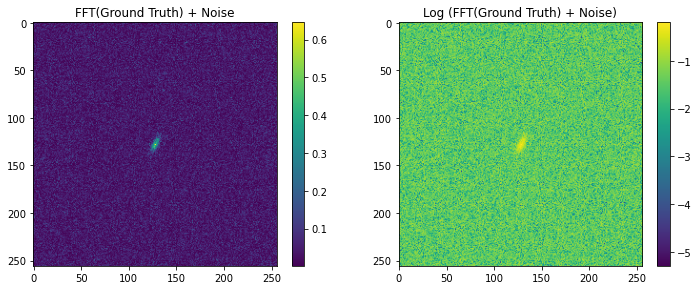

0.05687359927909602


In [7]:
gal_fft = np.fft.fftshift(np.fft.fft2(gal_up))   
psf_fft = np.fft.fftshift(np.fft.fft2(psf_up))      

# SNR(x) = l2_norm(x)/sigma_noise 

SNR = 50                                                          # Signal to noise ratio in Fourier domain
sigma_noise = np.linalg.norm(gal_fft)/SNR                         # Standard deviation of noise

gal_fft_GSO = galsim.Image(gal_fft, copy=True)                    # Stored as GSO
gal_fft_GSO.addNoise(galsim.GaussianNoise(sigma = sigma_noise)) 

fig = plt.figure(figsize=(12,12))

plt.subplot(121)
plt.imshow(np.abs(gal_fft_GSO.array))
plt.colorbar(shrink=0.375)
plt.title('FFT(Ground Truth) + Noise')

plt.subplot(122)
plt.imshow(np.log10(np.abs(gal_fft_GSO.array)))
plt.colorbar(shrink=0.375)
plt.title('Log (FFT(Ground Truth) + Noise)')

plt.show()

print(sigma_noise)

### Convolve with PSF

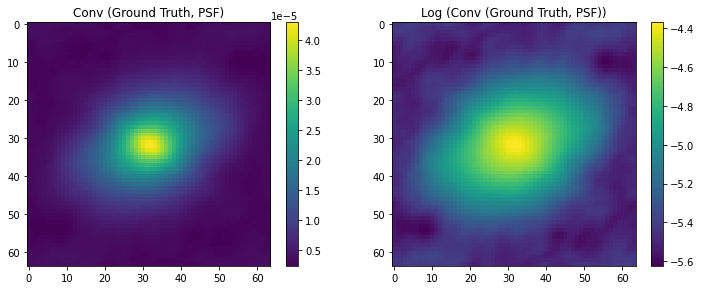

(0.030397305292520813, 0.030397305292520813)

In [8]:
conv = gal_fft_GSO.array * psf_fft

final_gal = np.real(np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(conv))))     # IFFT to get back to brightness domain
final_gal = cv.resize(final_gal, (64,64))    
final_gal *= (np.sum(gal)/np.sum(final_gal))                                   # Normalisation

fig = plt.figure(figsize=(12,12))

plt.subplot(121)
plt.imshow(final_gal)
plt.colorbar(shrink=0.375)
plt.title('Conv (Ground Truth, PSF)')

plt.subplot(122)
plt.imshow(np.log10(final_gal))
plt.colorbar(shrink=0.375)
plt.title('Log (Conv (Ground Truth, PSF))')

plt.show()

np.sum(final_gal), np.sum(gal)

# FISTA

In [9]:
# Utility Functions

def fftconvolve(image, kernel):

    x = np.fft.fftshift(np.fft.fftn(image))
    y = np.fft.fftshift(np.fft.fftn(kernel))

    return np.real(np.fft.fftshift(np.fft.ifftn(np.fft.ifftshift(x * y))))

def l1_norm(signal):

    return np.sum(np.abs(signal))

def fft(data):

    return (1 / np.sqrt(data.size) *
            np.fft.fftshift(np.fft.fftn(np.fft.ifftshift(data))))

def ifft(data):

    return (np.sqrt(data.size) *
            np.fft.fftshift(np.fft.ifftn(np.fft.ifftshift(data))))

def soft_thresh(data, threshold):

    return np.around(np.maximum((1.0 - threshold /
                     np.maximum(np.finfo(np.float64).eps,
                                np.abs(data))), 0.0) * data, decimals=15)

def nmse(signal_1, singal_2):

    return (np.linalg.norm(singal_2 - signal_1) ** 2 /
            np.linalg.norm(signal_1) ** 2)

In [10]:
# Project negative values
def proj(xi):
    
    return np.maximum(xi,0)


# H operator
def H(data, psf):
    
    return fftconvolve(data, psf)

# H transpose operator
def Ht(data, psf):
    
    return fftconvolve(data, np.rot90(psf, 2))


# The gradient
def grad(y, alpha_rec, psf):

    return fft(Ht(H(ifft(alpha_rec), psf) - y, psf))


# The cost function
def cost_func(y, alpha_rec, psf, lambda_):

    return (0.5 * np.linalg.norm(y - H(ifft(alpha_rec), psf)) ** 2 + lambda_ * np.linalg.norm(alpha_rec))


def runFISTA(observation, first_guess, psf, grad, n_iter, disp_step, lambda_val, gamma=1.0, ST_lambda=1e-10):
    
    cost = []
    nmse_arr = np.full(n_iter, np.inf)
    x_opt = np.zeros(observation.shape)
    count = 0
    
    # FISTA Parameters
    t_k = 1
    alpha_rec = first_guess
    xk = alpha_rec
            
    for i in range(n_iter):
        
        # FISTA Update
        x_k1 = xk
        alpha_temp = alpha_rec - gamma*grad(observation, alpha_rec, psf)
        alpha_temp = soft_thresh(alpha_temp, ST_lambda)
        xk = proj(alpha_temp)
        t_k1 = (1 + np.sqrt(1 + 4*t_k**2))/2
        alpha_rec = xk + (t_k - 1)/t_k1*(xk - x_k1)
        t_k = t_k1          
        
        cost.append(cost_func(observation, alpha_rec, psf, lambda_val))
        
        # Convert back to signal domain
        x_rec = np.abs(ifft(alpha_rec))
        
        # Compute NMSE
        nmse_arr[i] = nmse(gal, x_rec)  
        
        # Check if optimal reconstruction is achieved
        if nmse_arr[i]==np.min(nmse_arr):
            x_opt = x_rec

        if (i+1)%disp_step==0 and i!=0:
            plot_utils.plot_iter_np(x_rec, gal, observation, i)
    
    return x_rec, x_opt, nmse_arr, cost

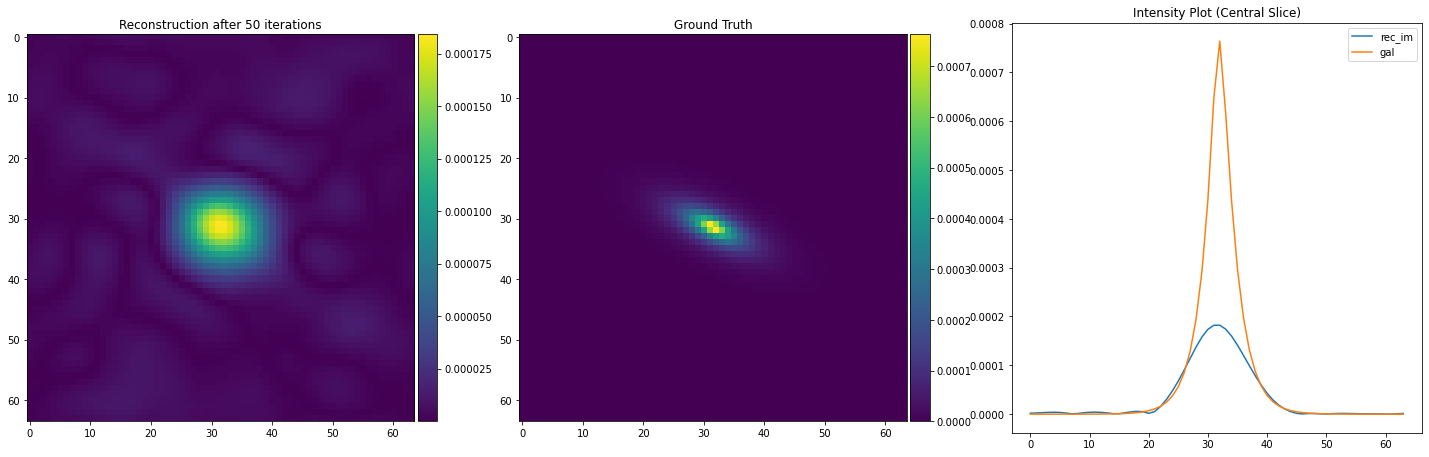

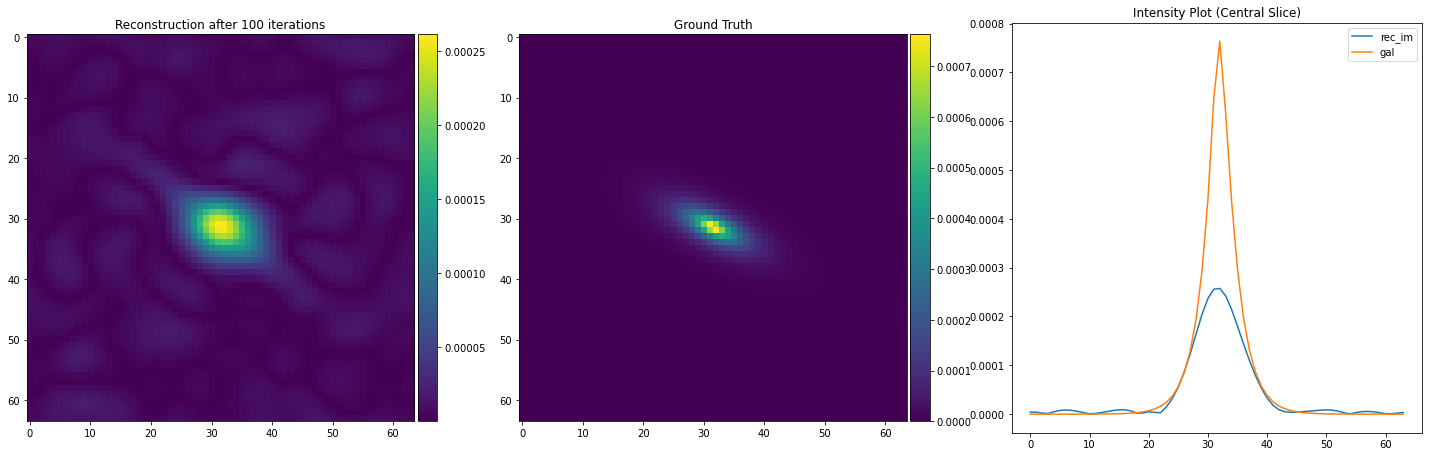

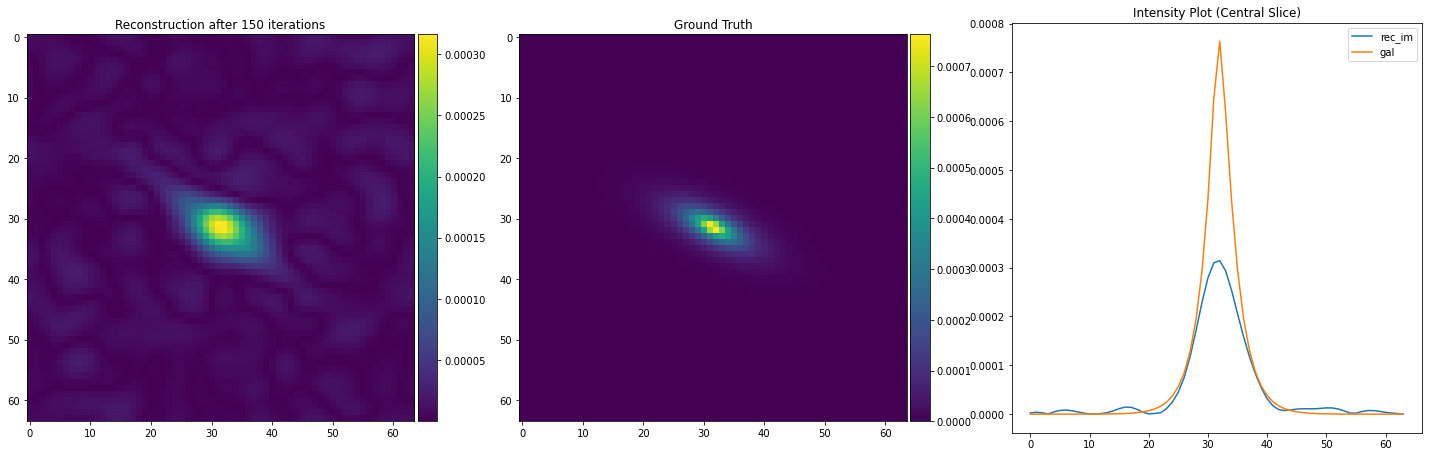

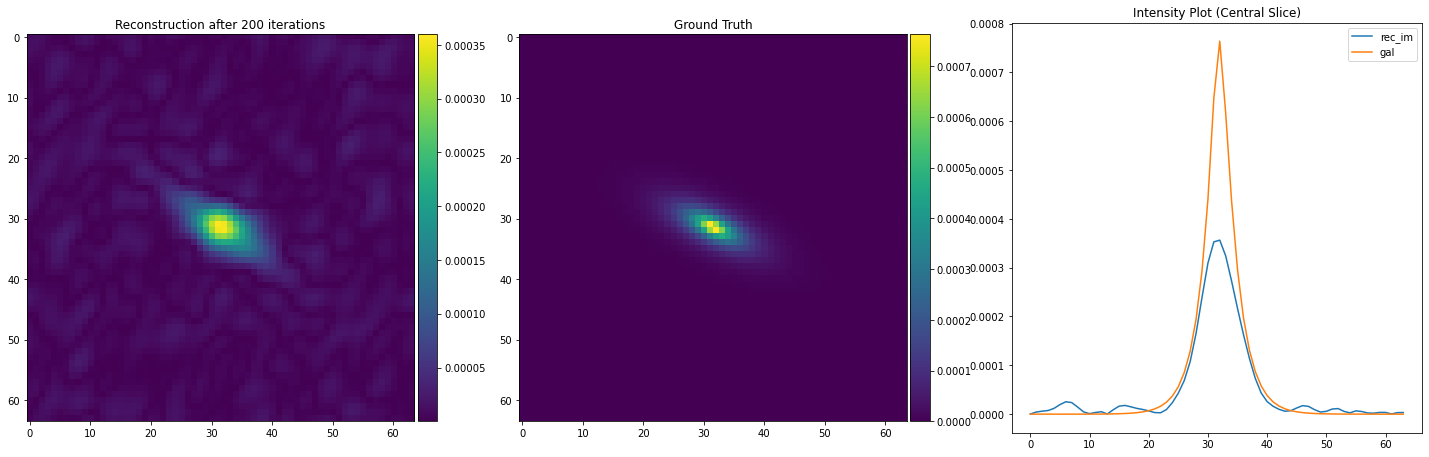

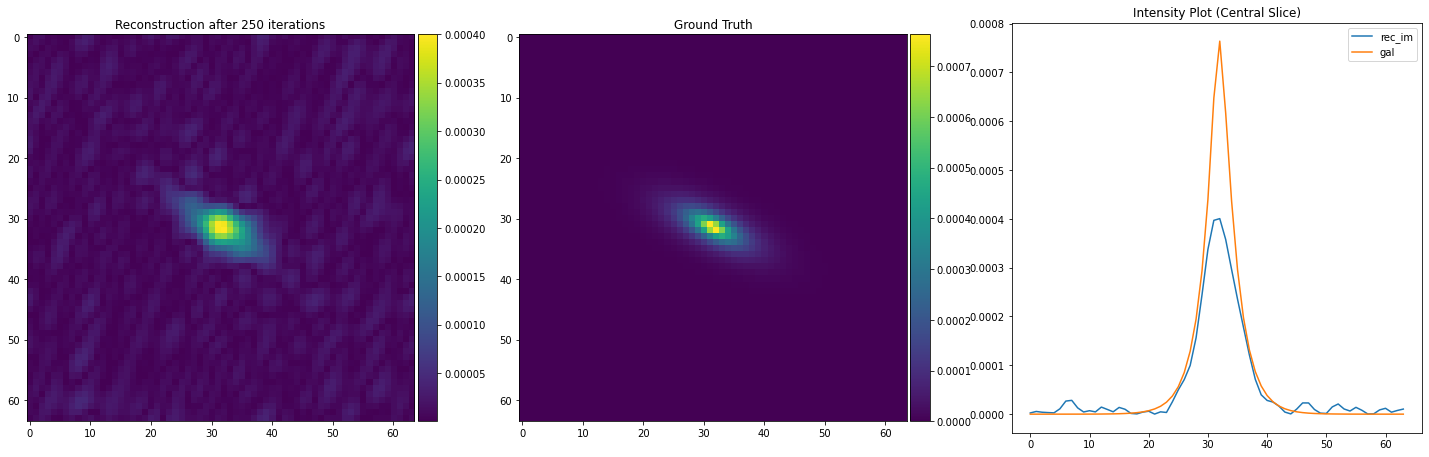

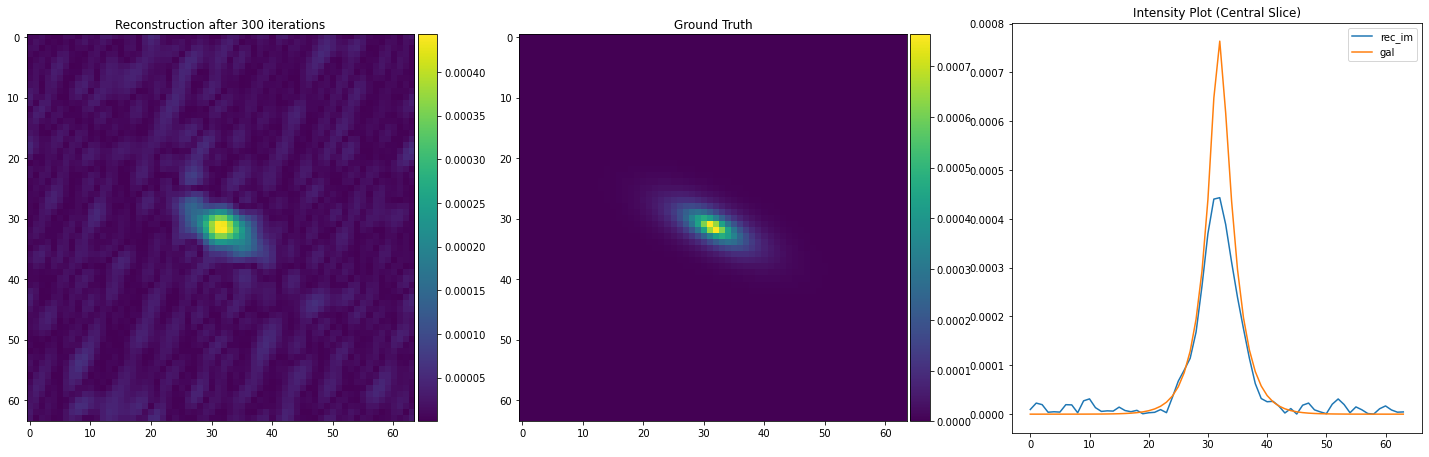

In [11]:
# Number of Iterations
n_iter = 300
disp_step = 50

# Deconvolve the image
x_rec, x_opt, nmse_arr, cost = runFISTA(final_gal, np.zeros(final_gal.shape), psf, grad, 
                                        n_iter, disp_step, lambda_val=1e-4)

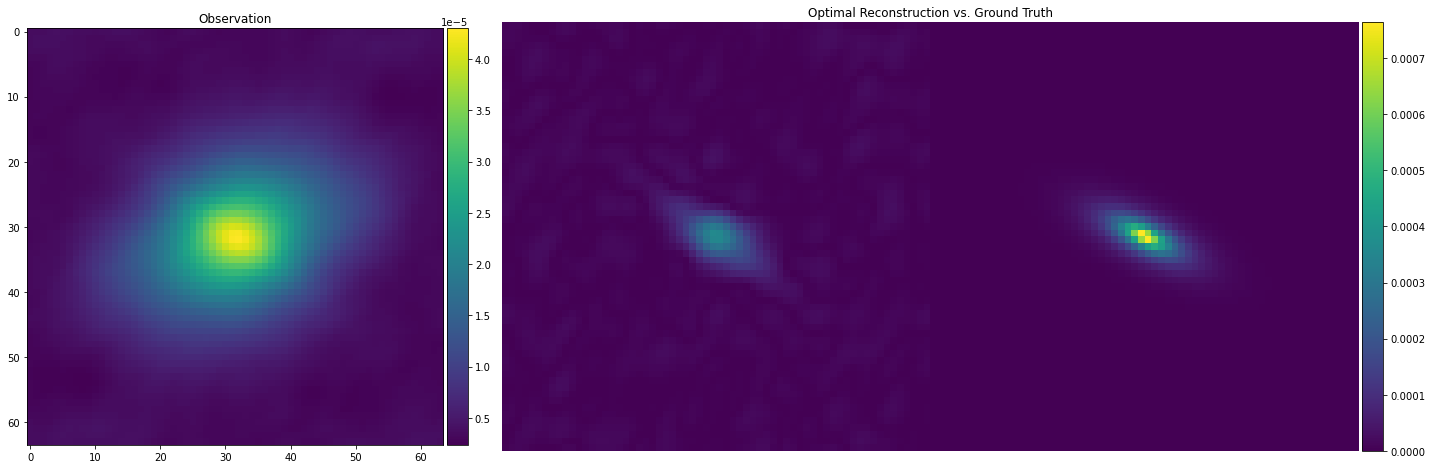

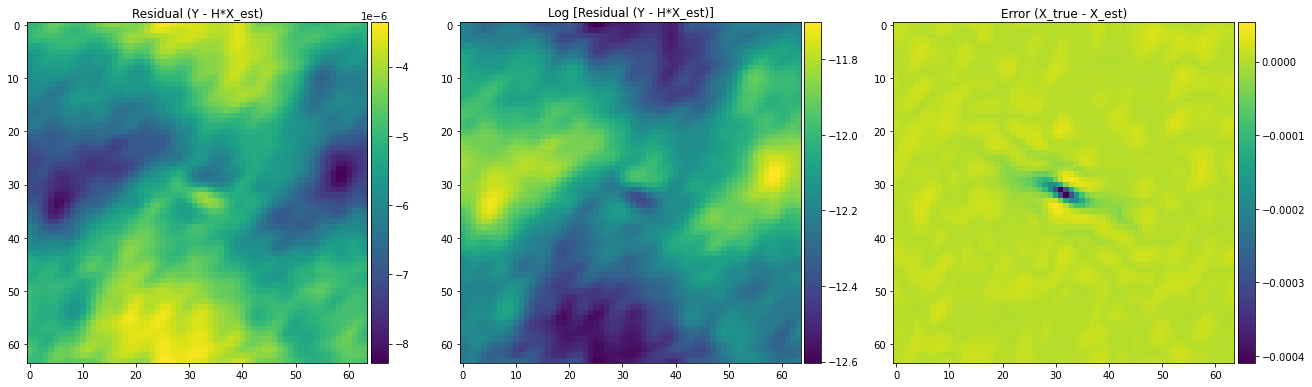

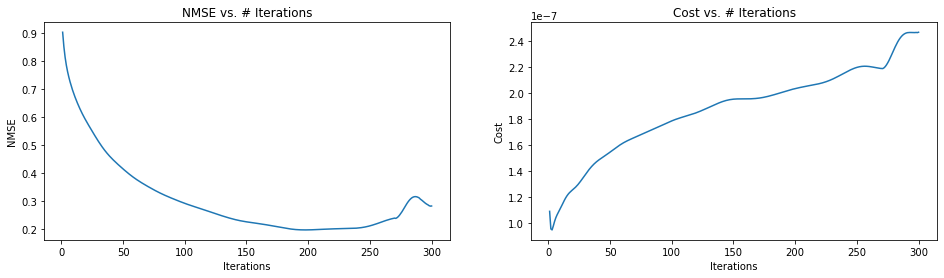


Minimum NMSE = 0.19650892535420716 (at [198] iterations)
Minimum Cost = 9.46190971919092e-08 (at [3] iterations)


In [12]:
plot_utils.comparison_np(x_opt, gal, final_gal, psf, fftconvolve, fft)
plot_utils.nmse_cost(nmse_arr, cost, n_iter)